In [1]:
# import gzip
# import shutil
# from astropy.io import fits

# # Input and output file paths
# input_gz_file = '/u/ywagh/gwemopt_tests/006.gz'
# output_fits_file = '/u/ywagh/gwemopt_tests/006.fits'

# # Decompress the .gz file
# with gzip.open(input_gz_file, 'rb') as f_in:
#     with open(output_fits_file, 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

# # Open the FITS file to ensure it's correctly decompressed
# with fits.open(output_fits_file) as hdul:
#     print(hdul.info())


Filename: /u/ywagh/gwemopt_tests/006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     51   49152R x 4C   [D, D, D, D]   
None


In [31]:
import astroplan
from astropy.coordinates import ICRS, SkyCoord, AltAz, get_moon, EarthLocation, get_body
from astropy import units as u
from astropy.utils.data import download_file
from astropy.table import Table, QTable, join
from astropy.time import Time, TimeDelta
from astropy_healpix import *
from ligo.skymap import plot
from ligo.skymap.io import read_sky_map
import healpy as hp
import os
from matplotlib import pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import datetime as dt
import pickle
import pandas as pd
from docplex.mp.model import Model

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
warnings.simplefilter('ignore', astroplan.TargetNeverUpWarning)
warnings.simplefilter('ignore', astroplan.TargetAlwaysUpWarning)

# directory_path = "/u/ywagh/test_skymaps/S240422ed.fits"
# skymap, metadata = read_sky_map(os.path.join(directory_path))

directory_path = "/u/ywagh/test_skymaps/"
filelist = sorted([f for f in os.listdir(directory_path) if f.endswith('.gz')])

slew_speed = 2.5 * u.deg / u.s
slew_accel = 0.4 * u.deg / u.s**2
readout = 8.2 * u.s

ns_nchips = 4
ew_nchips = 4
ns_npix = 6144
ew_npix = 6160
plate_scale = 1.01 * u.arcsec
ns_chip_gap = 0.205 * u.deg
ew_chip_gap = 0.140 * u.deg

ns_total = ns_nchips * ns_npix * plate_scale + (ns_nchips - 1) * ns_chip_gap
ew_total = ew_nchips * ew_npix * plate_scale + (ew_nchips - 1) * ew_chip_gap

rcid = np.arange(64)

chipid, rc_in_chip_id = np.divmod(rcid, 4)
ns_chip_index, ew_chip_index = np.divmod(chipid, ew_nchips)
ns_rc_in_chip_index = np.where(rc_in_chip_id <= 1, 1, 0)
ew_rc_in_chip_index = np.where((rc_in_chip_id == 0) | (rc_in_chip_id == 3), 0, 1)

ew_offsets = ew_chip_gap * (ew_chip_index - (ew_nchips - 1) / 2) + ew_npix * plate_scale * (ew_chip_index - ew_nchips / 2) + 0.5 * ew_rc_in_chip_index * plate_scale * ew_npix
ns_offsets = ns_chip_gap * (ns_chip_index - (ns_nchips - 1) / 2) + ns_npix * plate_scale * (ns_chip_index - ns_nchips / 2) + 0.5 * ns_rc_in_chip_index * plate_scale * ns_npix

ew_ccd_corners = 0.5 * plate_scale * np.asarray([ew_npix, 0, 0, ew_npix])
ns_ccd_corners = 0.5 * plate_scale * np.asarray([ns_npix, ns_npix, 0, 0])

ew_vertices = ew_offsets[:, np.newaxis] + ew_ccd_corners[np.newaxis, :]
ns_vertices = ns_offsets[:, np.newaxis] + ns_ccd_corners[np.newaxis, :]

def get_footprint(center):
    return SkyCoord(
        ew_vertices, ns_vertices,
        frame=center[..., np.newaxis, np.newaxis].skyoffset_frame()
    ).icrs

url = 'https://github.com/ZwickyTransientFacility/ztf_information/raw/master/field_grid/ZTF_Fields.txt'
filename = download_file(url)
field_grid = QTable(np.recfromtxt(filename, comments='%', usecols=range(3), names=['field_id', 'ra', 'dec']))
field_grid['coord'] = SkyCoord(field_grid.columns.pop('ra') * u.deg, field_grid.columns.pop('dec') * u.deg)
field_grid = field_grid[0:881]

#******************************************************************************
skymap, metadata = read_sky_map(os.path.join(directory_path, filelist[7]))

plot_filename = os.path.basename(filelist[7])
print(plot_filename)
# plot_filename = 'S240422ed'
# ci
#******************************************************************************

event_time = Time(metadata['gps_time'], format='gps').utc
event_time.format = 'iso'
print('event time:',event_time)
observer = astroplan.Observer.at_site('Palomar')
night_horizon = -18 * u.deg
if observer.is_night(event_time, horizon=night_horizon):
    start_time = event_time
else:
    start_time = observer.sun_set_time(
        event_time, horizon=night_horizon, which='next')

# Find the latest possible end time of observations: the time of sunrise.
end_time = observer.sun_rise_time(
    start_time, horizon=night_horizon, which='next')

min_airmass = 2.5 * u.dimensionless_unscaled
airmass_horizon = (90 * u.deg - np.arccos(1 / min_airmass))
targets = field_grid['coord']

# Find the time that each field rises and sets above an airmass of 2.5.
target_start_time = Time(np.where(
    observer.target_is_up(start_time, targets, horizon=airmass_horizon),
    start_time,
    observer.target_rise_time(start_time, targets, which='next', horizon=airmass_horizon)))
target_start_time.format = 'iso'

# Find the time that each field sets below the airmass limit. If the target
# is always up (i.e., it's circumpolar) or if it sets after surnsise,
# then set the end time to sunrise.
target_end_time = observer.target_set_time(
    target_start_time, targets, which='next', horizon=airmass_horizon)
target_end_time[
    (target_end_time.mask & ~target_start_time.mask) | (target_end_time > end_time)
] = end_time
target_end_time.format = 'iso'
# Select fields that are observable for long enough for at least one exposure
##############################################################################
exposure_time = 180 * u.second
exposure_time_day = exposure_time.to_value(u.day)

num_visits = 3
num_filters = 1

cadence = 30         #minutes
cadence_days = cadence / (60 * 24)
##############################################################################
field_grid['start_time'] = target_start_time
field_grid['end_time'] = target_end_time
observable_fields = field_grid[target_end_time - target_start_time >= exposure_time]

# print(observable_fields)
hpx = HEALPix(nside=256, frame=ICRS())

footprint = np.moveaxis(
    get_footprint(SkyCoord(0 * u.deg, 0 * u.deg)).cartesian.xyz.value, 0, -1)
footprint_healpix = np.unique(np.concatenate(
    [hp.query_polygon(hpx.nside, v, nest=(hpx.order == 'nested')) for v in footprint]))

'''
# computing the footprints of every ZTF field as HEALPix indices. Downsampling skymap to same resolution.
'''
footprints = np.moveaxis(get_footprint(observable_fields['coord']).cartesian.xyz.value, 0, -1)
footprints_healpix = [
    np.unique(np.concatenate([hp.query_polygon(hpx.nside, v) for v in footprint]))
    for footprint in tqdm(footprints)]

prob = hp.ud_grade(skymap, hpx.nside, power=-2)

# k = max number of 300s exposures 
min_start = min(observable_fields['start_time'])
max_end =max(observable_fields['end_time'])
# min_start.format = 'jd'
# max_end.format = 'jd'

# k=30

k = int(np.floor((max_end - min_start)/(exposure_time.to(u.day))))
k = np.floor(k/(num_visits*num_filters))
print(k," number of exposures could be taken tonight")

print("problem setup completed")

008.gz
event time: 2019-12-12 08:27:28.643


/u/ywagh/.local/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


  0%|          | 0/396 [00:00<?, ?it/s]

31.0  number of exposures could be taken tonight
problem setup completed


In [4]:
directory_path = "/u/ywagh/test_skymaps/"
filelist = sorted([f for f in os.listdir(directory_path) if f.endswith('.gz')])
print(filelist)

['001.gz', '002.gz', '003.gz', '004.gz', '005.gz', '006.gz', '007.gz', '008.gz', '009.gz', '010.gz', '011.gz', '012.gz', '013.gz', '014.gz', '015.gz', '016.gz', '017.gz', '018.gz', '019.gz', '020.gz', '021.gz', '022.gz', '023.gz', '024.gz', '025.gz', '026.gz', '027.gz', '028.gz', '029.gz', '030.gz', '031.gz', '032.gz', '033.gz', '034.gz', '035.gz', '036.gz', '037.gz', '038.gz', '039.gz', '040.gz', '041.gz', '042.gz', '043.gz', '044.gz', '045.gz', '046.gz', '047.gz', '048.gz', '049.gz', '050.gz', '051.gz', '052.gz', '053.gz', '054.gz', '055.gz', '056.gz', '057.gz', '058.gz', '059.gz', '060.gz', '061.gz', '062.gz', '063.gz', '064.gz', '065.gz', '066.gz', '067.gz', '068.gz', '069.gz', '070.gz', '071.gz', '072.gz', '073.gz', '074.gz', '075.gz', '076.gz', '077.gz', '078.gz', '079.gz', '080.gz', '081.gz', '082.gz', '083.gz', '084.gz', '085.gz', '086.gz', '087.gz', '088.gz', '089.gz', '090.gz', '091.gz', '092.gz', '093.gz', '094.gz', '095.gz', '096.gz', '097.gz', '098.gz', '099.gz', '100.gz',

In [28]:
print(start_time.mjd)
print(end_time.iso)
print(end_time-start_time)
start = start_time.mjd
f = (end_time-start_time).value
f

60563.14256418031
2024-09-10 12:03:45.838
0.3600496891885996


0.3600496891885996

In [32]:
m1 = Model('max coverage problem')

field_vars = m1.binary_var_list(len(footprints), name='field')
pixel_vars = m1.binary_var_list(hpx.npix, name='pixel')

footprints_healpix_inverse = [[] for _ in range(hpx.npix)]

for field, pixels in enumerate(footprints_healpix):
    for pixel in pixels:
        footprints_healpix_inverse[pixel].append(field)

for i_pixel, i_fields in enumerate(footprints_healpix_inverse):
     m1.add_constraint(m1.sum(field_vars[i] for i in i_fields) >= pixel_vars[i_pixel])

m1.add_constraint(m1.sum(field_vars) <= k)
m1.maximize(m1.dot(pixel_vars, prob))
print(f"number fo fields observed should be less than {k}")

solution = m1.solve(log_output=True)

print("optimization completed")
total_prob_covered = solution.objective_value

print("Total probability covered:",total_prob_covered)

selected_fields_ID = [i for i, v in enumerate(field_vars) if v.solution_value == 1]
print(len(selected_fields_ID), "fields selected")
selected_fields = observable_fields[selected_fields_ID]
# print(selected_fields)

separation_matrix = selected_fields['coord'][:,np.newaxis].separation(selected_fields['coord'][np.newaxis,:])

def slew_time(separation):
   return np.where(separation <= (slew_speed**2 / slew_accel),
                   np.sqrt(2 * separation / slew_accel),
                   (2 * slew_speed / slew_accel) + (separation - slew_speed**2 / slew_accel) / slew_speed)

slew_times = slew_time(separation_matrix).value

slew_time_value = slew_times*u.second
slew_time_day = slew_time_value.to_value(u.day)

number fo fields observed should be less than 31.0
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.02 sec. (24.20 ticks)
Tried aggregator 3 times.
MIP Presolve eliminated 785920 rows and 728660 columns.
Aggregator did 98 substitutions.
Reduced MIP has 415 rows, 512 columns, and 1596 nonzeros.
Reduced MIP has 512 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.57 sec. (694.93 ticks)
Probing time = 0.00 sec. (0.11 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 415 rows, 512 columns, and 1596 nonzeros.
Reduced MIP has 512 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.10 ticks)
Probing time = 0.00 sec. (0.11 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 32 threads.
Root relaxation solution time = 0.01 sec. (0.60 ticks)

        Nodes

In [27]:
a= np.mean(slew_times)
a

17.866043172339463

Text(0.05, 0.95, 'Total Probability Covered: 0.77')

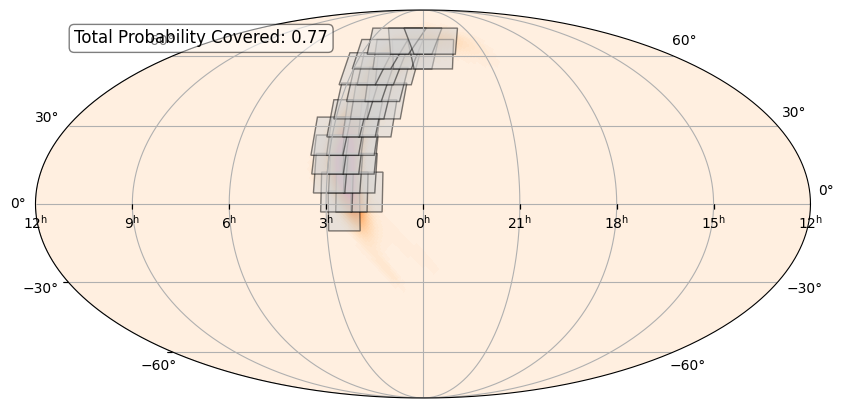

In [33]:
plt.figure(figsize=(10, 8))
#off-center case
# ax = plt.axes(projection='astro mollweide', center='0h 60d')
ax = plt.axes(projection='astro mollweide', center='0h 0d')

for row in selected_fields:
    coords = SkyCoord(
        [ew_total, -ew_total, -ew_total, ew_total],
        [ns_total, ns_total, -ns_total, -ns_total],
        frame=row['coord'].skyoffset_frame()
    ).icrs
    ax.add_patch(plt.Polygon(
        np.column_stack((coords.ra.deg, coords.dec.deg)),
        alpha=0.5,
        facecolor='lightgray',
        edgecolor='black',
        transform=ax.get_transform('world')
    ))
# plot_filename = os.path.basename(skymap_file)
plot_filename = 'S240910ci'
ax.grid()
ax.imshow_hpx(prob, cmap='cylon')
plt.text(0.05, 0.95, f'Total Probability Covered: {total_prob_covered:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

In [7]:
from astropy import units as u

exp_time_list = [60, 120, 180, 240]
for i in range(len(exp_time_list)):
    exposure_time = exp_time_list[i] * u.second
    print(exposure_time)

60.0 s
120.0 s
180.0 s
240.0 s


In [12]:
end_time.jd

2458580.0026574824

In [6]:
delta = exposure_time.to_value(u.day)

limit_duration = ((end_time-start_time).value*2/3) 
filtered_rows = [
    row for row in selected_fields
    if (row['end_time'] - row['start_time']).to_value(u.day) > limit_duration
]

# Create a new QTable with the filtered rows
selected_fil_fileds = QTable(rows=filtered_rows, names=selected_fields.colnames)

selected_fil_fileds

field_id,coord,start_time,end_time
,"deg,deg",,
int64,SkyCoord,Time,Time
576,"187.38957,18.95",2019-04-06 03:35:46.123,2019-04-06 12:03:49.606
577,"194.55043,18.95",2019-04-06 03:35:46.123,2019-04-06 12:03:49.606
578,"201.71129,18.95",2019-04-06 03:35:46.123,2019-04-06 12:03:49.606
584,"245.31027,18.95",2019-04-06 06:17:45.802,2019-04-06 12:03:49.606
625,"188.50914,26.15",2019-04-06 03:35:46.123,2019-04-06 12:03:49.606
626,"195.99086,26.15",2019-04-06 03:35:46.123,2019-04-06 12:03:49.606
627,"203.47257,26.15",2019-04-06 03:35:46.123,2019-04-06 12:03:49.606
632,"240.88114,26.15",2019-04-06 05:43:32.921,2019-04-06 12:03:49.606


In [ ]:
selected_fil_fileds

In [19]:
# Verify time windows for each field
for i, row in enumerate(selected_fields):
    print(f"Field {i}:")
    print(f"Start time: {row['start_time']}")
    print(f"End time: {row['end_time']}")
    print(f"Window duration: {row['end_time'] - row['start_time']}")
    delta = exposure_time.to_value(u.day)

    if (row['end_time'] - row['start_time']).to_value(u.day) < (num_visits * num_filters * delta):
        print(f"Warning: Time window might be too short for field {i}")

Field 0:
Start time: 2024-09-09 03:26:48.390
End time: 2024-09-09 05:00:03.332
Window duration: 0.0647562718950212
Field 1:
Start time: 2024-09-09 03:26:48.390
End time: 2024-09-09 05:31:21.466
Window duration: 0.08649393543601036
Field 2:
Start time: 2024-09-09 03:56:36.988
End time: 2024-09-09 06:02:35.282
Window duration: 0.08748025912791485
Field 3:
Start time: 2024-09-09 04:27:18.890
End time: 2024-09-09 06:33:42.663
Window duration: 0.08777514239773149
Field 4:
Start time: 2024-09-09 04:57:59.725
End time: 2024-09-09 07:04:48.068
Window duration: 0.08805951708927745
Field 5:
Start time: 2024-09-09 05:28:39.891
End time: 2024-09-09 07:35:51.312
Window duration: 0.08832662971690292
Field 6:
Start time: 2024-09-09 03:26:48.390
End time: 2024-09-09 05:32:22.050
Window duration: 0.08719513844698668
Field 7:
Start time: 2024-09-09 03:26:48.390
End time: 2024-09-09 06:01:58.123
Window duration: 0.10775153897702688
Field 8:
Start time: 2024-09-09 03:26:48.390
End time: 2024-09-09 06:31:3

Window duration: 0.1393698072060942
Field 37:
Start time: 2024-09-09 03:26:48.390
End time: 2024-09-09 07:16:32.017
Window duration: 0.15953271603211755
Field 38:
Start time: 2024-09-09 05:26:22.200
End time: 2024-09-09 12:02:56.903
Window duration: 0.275401652790606
Field 39:
Start time: 2024-09-09 03:26:48.390
End time: 2024-09-09 06:47:56.945
Window duration: 0.13968234043568367
Field 40:
Start time: 2024-09-09 03:26:48.390
End time: 2024-09-09 07:17:49.690
Window duration: 0.16043171193450684
Field 41:
Start time: 2024-09-09 05:12:41.584
End time: 2024-09-09 12:02:56.903
Window duration: 0.28489952767267823
Field 42:
Start time: 2024-09-09 03:26:48.390
End time: 2024-09-09 06:45:25.714
Window duration: 0.1379319918341934
Field 43:
Start time: 2024-09-09 03:26:48.390
End time: 2024-09-09 07:16:47.020
Window duration: 0.15970635693520302
Field 44:
Start time: 2024-09-09 04:44:38.045
End time: 2024-09-09 12:02:56.903
Window duration: 0.3043849263340235
Field 45:
Start time: 2024-09-09

In [7]:
m2 = Model("Telescope timings")

observer_location = EarthLocation.of_site('Palomar')

footprints_selected = np.moveaxis(get_footprint(selected_fil_fileds['coord']).cartesian.xyz.value, 0, -1)
footprints_healpix_selected = [
    np.unique(np.concatenate([hp.query_polygon(hpx.nside, v) for v in footprint]))
    for footprint in tqdm(footprints_selected)]

probabilities = []

for field_index in range(len(footprints_healpix_selected)):
    probability_field = np.sum(prob[footprints_healpix_selected[field_index]])
    probabilities.append(probability_field)
print("worked for",len(probabilities),"fields")

selected_fil_fileds['probabilities'] = probabilities

delta = exposure_time.to_value(u.day)
M = (selected_fil_fileds['end_time'].max() - selected_fil_fileds['start_time'].min()).to_value(u.day).item()

x = [[m2.binary_var(name=f"x_{i}_visit_{v}") 
      for v in range(num_visits*num_filters)] 
      for i in range(len(selected_fil_fileds))]

tc = [[m2.continuous_var(
    lb=(row['start_time'] - start_time).to_value(u.day),
    ub=(row['end_time'] - start_time - exposure_time).to_value(u.day),
    name=f"start_time_field_{i}_visit_{v}")
    for v in range(num_visits*num_filters)] 
    for i, row in enumerate(selected_fil_fileds)]

visit_transition_times = [m2.continuous_var(
    lb=0,ub=M,name=f"visit_transition_{v}")
                          for v in range(num_visits*num_filters-1)]  

# Isolating visits
for v in range(1, num_visits*num_filters):
    for i in range(len(selected_fil_fileds)):
        m2.add_constraint(tc[i][v-1] + delta * x[i][v-1] <= visit_transition_times[v-1],
            ctname=f"visit_end_{i}_visit_{v-1}")
        m2.add_constraint(tc[i][v] >= visit_transition_times[v-1],
            ctname=f"visit_start_{i}_visit_{v}")


# Cadence constraints
for i in range(len(selected_fil_fileds)):
    for v in range(1, num_visits*num_filters):
        m2.add_constraint(tc[i][v] - tc[i][v-1] >= (cadence_days+delta) * (x[i][v] + x[i][v-1] - 1),
            ctname=f"cadence_constraint_field_{i}_visits_{v}")

#non-overlapping
for v in range(num_visits*num_filters):
    for i in range(len(selected_fil_fileds)):
        for j in range(i):
            m2.add_constraint(tc[i][v] + delta * x[i][v] + slew_time_day[i][j] - tc[j][v] <= M * (2 - x[i][v] - x[j][v]),
                              ctname=f"non_overlapping_cross_fields_{i}_{j}_visits_{v}")
            m2.add_constraint(tc[j][v] + delta * x[j][v] + slew_time_day[i][j] - tc[i][v] <= M * (-1 + x[i][v] + x[j][v]),
                ctname=f"non_overlapping_cross_fields_{j}_{i}_visits_{v}")

# Initialize the objective
m2.maximize(
    m2.sum(probabilities[i] * x[i][v]
           for i in range(len(selected_fil_fileds))
           for v in range(num_visits*num_filters))
)

# m2.parameters.timelimit = 60
m2.parameters.mip.tolerances.mipgap = 0.01  # 1% optimality gap
m2.parameters.emphasis.mip = 2  # Emphasize optimality over feasibility
solution = m2.solve(log_output=True)

  0%|          | 0/45 [00:00<?, ?it/s]

worked for 45 fields
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Emphasis_MIP                            2
CPXPARAM_MIP_Tolerances_MIPGap                   0.01
Tried aggregator 1 time.
MIP Presolve modified 16766 coefficients.
Reduced MIP has 6210 rows, 272 columns, and 24570 nonzeros.
Reduced MIP has 135 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (14.90 ticks)

Root node processing (before b&c):
  Real time             =    0.22 sec. (198.64 ticks)
Parallel b&c, 32 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.22 sec. (198.64 ticks)


In [8]:
solution.objective_value/(num_visits * num_filters)

AttributeError: 'NoneType' object has no attribute 'objective_value'

In [21]:

scheduled_fields_by_visit = []
for v in range(num_visits * num_filters):
    visit_fields = [i for i in range(len(selected_fil_fileds)) if solution.get_value(x[i][v]) == 1]
    scheduled_fields_by_visit.append(visit_fields)

scheduled_fields = selected_fil_fileds.copy()

scheduled_tc = []
for v in range(num_visits * num_filters):
    visit_times = []
    for i in range(len(selected_fil_fileds)):
        if i in scheduled_fields_by_visit[v]:
            visit_times.append(solution.get_value(tc[i][v]))
        else:
            visit_times.append(np.nan) 
    scheduled_tc.append(visit_times)

scheduled_tc = np.array(scheduled_tc).T  

for i in range(num_visits * num_filters):
    scheduled_fields[f"Scheduled_start_filt_times_{i}"] = scheduled_tc[:, i]

for v in range(num_visits * num_filters):
    scheduled_fields[f"Selected_in_visit_{v}"] = [1 if i in scheduled_fields_by_visit[v] else 0 
                                                 for i in range(len(scheduled_fields))]

In [13]:
scheduled_tc


array([[0.00217589, 0.12994394, 0.15286061],
       [0.        , 0.10911061, 0.13202728]])

/u/ywagh/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 17 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/u/ywagh/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 17 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/u/ywagh/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 17 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/u/ywagh/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 17 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/u/ywagh/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 17 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {w

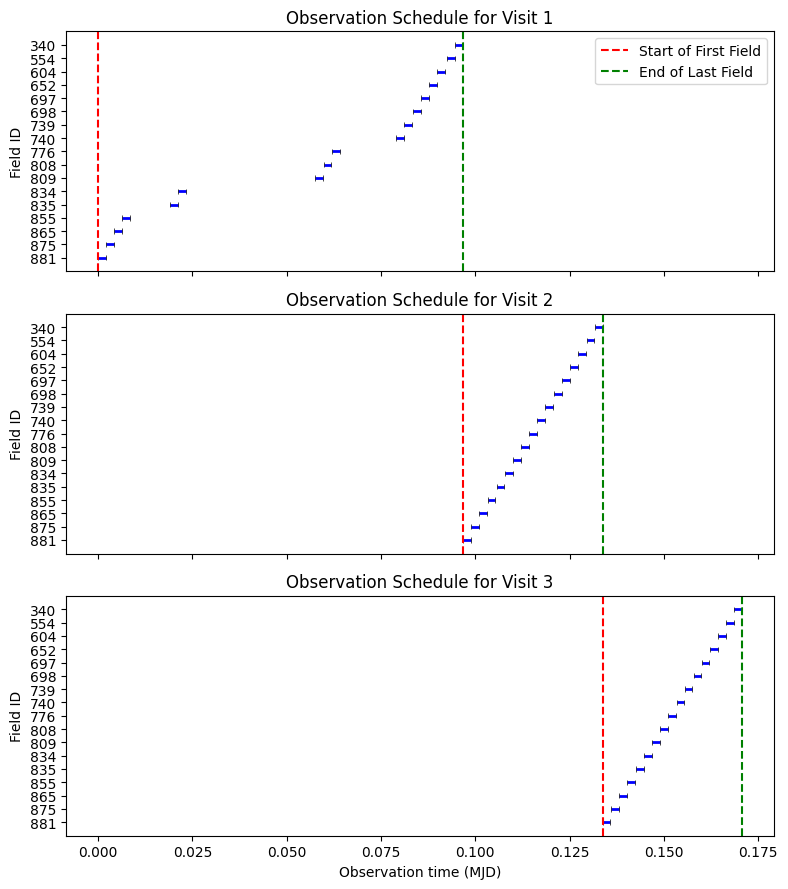

In [22]:
n_visits = num_visits * num_filters  

fig, axes = plt.subplots(n_visits, 1, figsize=(8, 3 * n_visits), sharex=True)

for i in range(n_visits):
    start_col = f'Scheduled_start_filt_times_{i}'
    end_col = f'Scheduled_end_filt_times_{i}'
    
    # Filter valid rows
    valid_rows = ~np.isnan(scheduled_tc).any(axis=1)
    valid_scheduled_tc = scheduled_tc[valid_rows]
    valid_scheduled_fields = scheduled_fields[valid_rows]
    
    if len(valid_scheduled_fields) == 0:
        print(f"No entries found for Visit {i + 1}. Skipping plot.")
        continue  # Skip this visit
    
    # Convert start times to ISO format and compute end times
    valid_scheduled_fields[start_col] = Time(valid_scheduled_fields[start_col], format='mjd')
    valid_scheduled_fields[start_col].format = 'iso'
    valid_scheduled_fields[end_col] = valid_scheduled_fields[start_col] + exposure_time_day
    
    # Sort fields by end time
    valid_scheduled_fields.sort(end_col)
    
    # Get the start and end times for plotting
    first_start_time = valid_scheduled_fields[start_col].mjd[0]
    last_end_time = valid_scheduled_fields[end_col].mjd[-1]
    
    ax = axes[i]
    ax.hlines(
        np.arange(len(valid_scheduled_fields)),
        valid_scheduled_fields[start_col].mjd,
        valid_scheduled_fields[end_col].mjd,
        colors='blue',
        linewidth=2
    )
    # Plot small vertical lines at start and end times of each interval
    for j in range(len(valid_scheduled_fields)):
        ax.vlines(
            valid_scheduled_fields[start_col][j].mjd,
            ymin=j - 0.2,
            ymax=j + 0.2,
            color='black',
            linewidth=0.5,
            linestyle='-'
        )
        ax.vlines(
            valid_scheduled_fields[end_col][j].mjd,
            ymin=j - 0.2,
            ymax=j + 0.2,
            color='black',
            linewidth=0.5,
            linestyle='-'
        )
    
    # Highlight first start and last end times
    if i == 0:  # Add legend only for the first subplot
        ax.axvline(first_start_time, color='red', linestyle='--', linewidth=1.5, label='Start of First Field')
        ax.axvline(last_end_time, color='green', linestyle='--', linewidth=1.5, label='End of Last Field')
        ax.legend(loc='upper right')
    else:
        ax.axvline(first_start_time, color='red', linestyle='--', linewidth=1.5)
        ax.axvline(last_end_time, color='green', linestyle='--', linewidth=1.5)
    
    # Add labels and title
    ax.set_yticks(np.arange(len(valid_scheduled_fields)))
    ax.set_yticklabels(valid_scheduled_fields['field_id'].astype(str))
    ax.set_ylabel('Field ID')
    ax.set_title(f'Observation Schedule for Visit {i + 1}')
    
axes[-1].set_xlabel('Observation time (MJD)')

plt.tight_layout()
# save_path = '/u/ywagh/scheduler_results/plots_manuscript'
# os.makedirs(save_path, exist_ok=True)  # Ensure directory exists
# full_path = os.path.join(save_path, f'schedule_revisit_.png')
# plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()


## model two

In [ ]:
m2 = Model("Telescope timings")

observer_location = EarthLocation.of_site('Palomar')

footprints_selected = np.moveaxis(get_footprint(selected_fields['coord']).cartesian.xyz.value, 0, -1)
footprints_healpix_selected = [
    np.unique(np.concatenate([hp.query_polygon(hpx.nside, v) for v in footprint]))
    for footprint in tqdm(footprints_selected)]

probabilities = []

for field_index in range(len(footprints_healpix_selected)):
    probability_field = np.sum(prob[footprints_healpix_selected[field_index]])
    probabilities.append(probability_field)
print("worked for",len(probabilities),"fields")

selected_fields['probabilities'] = probabilities

delta = exposure_time.to_value(u.day)
M = (selected_fields['end_time'].max() - selected_fields['start_time'].min()).to_value(u.day).item()

x = [[m2.binary_var(name=f"x_{i}_visit_{v}") 
      for v in range(num_visits*num_filters)] 
      for i in range(len(selected_fields))]

tc = [[m2.continuous_var(
    lb=(row['start_time'] - start_time).to_value(u.day),
    ub=(row['end_time'] - start_time - exposure_time).to_value(u.day),
    name=f"start_time_field_{i}_visit_{v}")
    for v in range(num_visits*num_filters)] 
    for i, row in enumerate(selected_fields)]

# Cadence constraints
for i in range(len(selected_fields)):
    for v in range(1, num_visits*num_filters):
        m2.add_constraint(tc[i][v] - tc[i][v-1] >= cadence_days * (x[i][v] + x[i][v-1] - 1),
            ctname=f"cadence_constraint_field_{i}_visits_{v}")

#non-overlapping
for v in range(num_visits*num_filters):
    for i in range(len(selected_fields)):
        for j in range(i):
            m2.add_constraint(tc[i][v] + delta * x[i][v] + slew_time_day[i][j] - tc[j][v] <= M * (2 - x[i][v] - x[j][v]),
                              ctname=f"non_overlapping_cross_fields_{i}_{j}_visits_{v}")
            m2.add_constraint(tc[j][v] + delta * x[j][v] + slew_time_day[i][j] - tc[i][v] <= M * (-1 + x[i][v] + x[j][v]),
                ctname=f"non_overlapping_cross_fields_{j}_{i}_visits_{v}")
            
# Create auxiliary variables for visit transition times
# visit_transition_times = [m2.continuous_var(
#     lb=0,  # or appropriate lower bound based on your problem
#     ub=M,  # your big-M value
#     name=f"visit_transition_{v}"
# ) for v in range(num_visits*num_filters-1)]  # one less than total visits

# # Add constraints for visit transitions
# for v in range(1, num_visits*num_filters):
#     # All fields from previous visit must end before transition time
#     for i in range(len(selected_fields)):
#         m2.add_constraint(
#             tc[i][v-1] + delta * x[i][v-1] <= visit_transition_times[v-1],
#             ctname=f"visit_end_{i}_visit_{v-1}"
#         )
        
#         # All fields in current visit must start after transition time
#         m2.add_constraint(
#             tc[i][v] >= visit_transition_times[v-1],
#             ctname=f"visit_start_{i}_visit_{v}"
#         )

# Isolating visits
for v in range(1, num_visits*num_filters):
    prev_visit_end = m2.max([tc[i][v-1] + 2 * delta * x[i][v-1] for i in range(len(selected_fields))])
    for i in range(len(selected_fields)):
        m2.add_constraint(tc[i][v] >= prev_visit_end,
            ctname=f"visit_sequence_field_{i}_visit_{v}")

m2.maximize(m2.sum([probabilities[i] * x[i][v]
                    for i in range(len(selected_fields))
                    for v in range(num_visits*num_filters)]))

m2.parameters.timelimit = 60
solution2 = m2.solve(log_output=True)

'''

# Visit ordering constraints
# for v in range(1, num_visits*num_filters):
#     for i in range(len(selected_fields)):
#         m2.add_constraint(tc[i][v] >= tc[len(selected_fields)-1][v-1] + delta + slew_time_day[][],
#                           ctname=f"visit_ordering_constraint_field_{i}_visit_{v}")
# Modified objective function to sum over fields and visits

for i in range(len(selected_fields)):
    for v in range(1, num_visits*num_filters):
        m2.add_constraint(tc[i][v] - tc[i][v-1] >= cadence_days * (x[i][v] + x[i][v-1] - 1),
            ctname=f"cadence_constraint_field_{i}_visits_{v}")

# For the first visit (v=0), use original constraints
for i in range(len(selected_fields)):
    for j in range(i):
        m2.add_constraint(
            tc[i][0] + delta * x[i][0] + slew_time_day[i][j] - tc[j][0] <= M * (2 - x[i][0] - x[j][0]),
            ctname=f"non_overlapping_cross_fields_{i}_{j}_visit_0"
        )
        m2.add_constraint(
            tc[j][0] + delta * x[j][0] + slew_time_day[i][j] - tc[i][0] <= M * (-1 + x[i][0] + x[j][0]),
            ctname=f"non_overlapping_cross_fields_{j}_{i}_visit_0"
        )

# For subsequent visits
for v in range(1, num_visits*num_filters):
    # Calculate end time of previous visit using all fields
    prev_visit_end = m2.max([
        tc[k][v-1] + delta * x[k][v-1]  
        for k in range(len(selected_fields))
    ])
    
    # For current visit
    for i in range(len(selected_fields)):
        # Ensure field starts after previous visit ends if it's selected
        m2.add_constraint(
            tc[i][v] >= prev_visit_end - M * (1 - x[i][v]),
            ctname=f"sequential_start_field_{i}_visit_{v}"
        )
        
        # Non-overlapping constraints within current visit
        for j in range(i):
            m2.add_constraint(
                tc[i][v] + delta * x[i][v] + slew_time_day[i][j] - tc[j][v] <= M * (2 - x[i][v] - x[j][v]),
                ctname=f"non_overlapping_cross_fields_{i}_{j}_visit_{v}"
            )
            m2.add_constraint(
                tc[j][v] + delta * x[j][v] + slew_time_day[i][j] - tc[i][v] <= M * (-1 + x[i][v] + x[j][v]),
                ctname=f"non_overlapping_cross_fields_{j}_{i}_visit_{v}"
            )
m2.maximize(m2.sum([
    probabilities[i] * x[i][v] 
    for i in range(len(selected_fields))
    for v in range(num_visits*num_filters)
]))

m2.parameters.timelimit = 60
solution = m2.solve(log_output=True)
'''

### exctracting solution

In [ ]:
solution2


In [ ]:
# scheduled_fields_by_visit = []
# for v in range(num_visits * num_filters):
#     visit_fields = [i for i in range(len(selected_fields)) if solution.get_value(x[i][v]) == 1]
#     scheduled_fields_by_visit.append(visit_fields)
# # scheduled_fields_by_visit

# scheduled_tc = []
# for v in range(num_visits * num_filters):
#     visit_times = []
#     for i in range(len(selected_fields)):
#         if i in scheduled_fields_by_visit[v]:
#             visit_times.append(solution.get_value(tc[i][v]))
#         else:
#             visit_times.append(np.nan) 
#     scheduled_tc.append(visit_times)
# scheduled_tc

In [ ]:
'''
# Get the indices of scheduled fields
scheduled_fields_ID = [i for i, v in enumerate(x) if v.solution_value == 1]
scheduled_fields = selected_fields[scheduled_fields_ID]
# scheduled_fields
scheduled_tc = [[solution.get_value(tc[i][v]) for v in range(num_visits * num_filters)] for i in scheduled_fields_ID]
scheduled_tc = np.asarray(scheduled_tc)
# scheduled_fields
for i in range(num_visits*num_filters):
    scheduled_fields[f"Scheduled_start_filt_times_{i}"] = scheduled_tc[:,i] 
'''
scheduled_fields_by_visit = []
for v in range(num_visits * num_filters):
    visit_fields = [i for i in range(len(selected_fields)) if solution.get_value(x[i][v]) == 1]
    scheduled_fields_by_visit.append(visit_fields)

scheduled_fields = selected_fields.copy()

scheduled_tc = []
for v in range(num_visits * num_filters):
    visit_times = []
    for i in range(len(selected_fields)):
        if i in scheduled_fields_by_visit[v]:
            visit_times.append(solution.get_value(tc[i][v]))
        else:
            visit_times.append(np.nan) 
    scheduled_tc.append(visit_times)

scheduled_tc = np.array(scheduled_tc).T  

for i in range(num_visits * num_filters):
    scheduled_fields[f"Scheduled_start_filt_times_{i}"] = scheduled_tc[:, i]

for v in range(num_visits * num_filters):
    scheduled_fields[f"Selected_in_visit_{v}"] = [1 if i in scheduled_fields_by_visit[v] else 0 
                                                 for i in range(len(selected_fields))]


In [ ]:
scheduled_tc

#### garbage

## plotting

In [ ]:
n_visits = num_visits * num_filters  

fig, axes = plt.subplots(n_visits, 1, figsize=(8, 3 * n_visits), sharex=True)

for i in range(n_visits):
    start_col = f'Scheduled_start_filt_times_{i}'
    end_col = f'Scheduled_end_filt_times_{i}'
    
    # Convert start times to MJD and set format
    scheduled_fields[start_col] = Time(scheduled_fields[start_col], format='mjd')
    scheduled_fields[start_col].format = 'iso'
    scheduled_fields[end_col] = scheduled_fields[start_col] + exposure_time_day
    
    # Sort fields by end time for better visualization
    scheduled_fields.sort(end_col)
    
    # Get the start and end times for the vertical lines
    first_start_time = scheduled_fields[start_col].mjd[0]
    last_end_time = scheduled_fields[end_col].mjd[-1]
    
    ax = axes[i]  
    # Plot observation time intervals as horizontal lines
    ax.hlines(
        np.arange(len(scheduled_fields)),
        scheduled_fields[start_col].mjd,
        scheduled_fields[end_col].mjd,
        colors='blue',
        linewidth=2
    )
    # Plot small vertical lines at start and end times of each interval
    for j in range(len(scheduled_fields)):
        ax.vlines(
            scheduled_fields[start_col][j].mjd,
            ymin=j - 0.2,
            ymax=j + 0.2,
            color='black',
            linewidth=0.5,
            linestyle='-'
        )
        ax.vlines(
            scheduled_fields[end_col][j].mjd,
            ymin=j - 0.2,
            ymax=j + 0.2,
            color='black',
            linewidth=0.5,
            linestyle='-'
        )
    
    # Plot big vertical lines at the start of the first field and end of the last field
    ax.axvline(first_start_time, color='red', linestyle='--', linewidth=1.5, label='Start of First Field')
    ax.axvline(last_end_time, color='green', linestyle='--', linewidth=1.5, label='End of Last Field')
    
    # Add labels and title
    ax.set_yticks(np.arange(len(scheduled_fields)))
    ax.set_yticklabels(scheduled_fields['field_id'].astype(str))
    ax.set_ylabel('Field ID')
    ax.set_title(f'Observation Schedule for Visit {i + 1}')
    ax.legend(loc='upper right')  # Add legend to distinguish vertical lines
    
axes[-1].set_xlabel('Observation time (MJD)')

plt.tight_layout()
plt.show()


In [ ]:
scheduled_fields

In [ ]:
# from docplex.mp.model import Model

# # Make sure all time values are in days
# exposure_time_day = exposure_time.to_value(u.day)
# cadence_days = cadence / (24 * 60)  # Convert minutes to days

# # Create and solve the model


# def create_observation_model(prob, observable_fields, exposure_time, cadence_days, slew_time_day, num_visits):
#     m = Model("Telescope Observation Schedule")
    
#     # Index sets
#     n_fields = len(observable_fields)
    
#     # Decision Variables
#     # p[i]: pixel i is inside footprint of selected fields (binary)
#     p = m.binary_var_list(len(prob), name='pixel')
    
#     # r[j]: field j is selected (binary)
#     r = m.binary_var_list(n_fields, name='field')
    
#     # t[j,k]: start time of observation j visit k (continuous)
#     t = [[m.continuous_var(
#         lb=(row['start_time'] - observable_fields['start_time'].min()).to_value(u.day),
#         ub=(row['end_time'] - observable_fields['start_time'].min() - exposure_time).to_value(u.day),
#         name=f"start_time_field_{j}_visit_{k}")
#         for k in range(num_visits)] for j, row in enumerate(observable_fields)]
    
#     # Containment Constraints
#     # A pixel is only counted if it's in a selected field
#     for i, fields_containing_pixel in enumerate(footprints_healpix_inverse):
#         m.add_constraint(
#             p[i] <= m.sum(r[j] for j in fields_containing_pixel),
#             ctname=f'containment_{i}'
#         )
    
#     # Cadence Constraints
#     # Minimum time between visits of the same field
#     for j in range(n_fields):
#         for k in range(1, num_visits):
#             m.add_constraint(
#                 t[j][k] - t[j][k-1] >= cadence_days * r[j],
#                 ctname=f'cadence_field_{j}_visit_{k}'
#             )
    
#     # No Overlap Constraints
#     # Observations must be separated by exposure + slew time
#     for j1 in range(n_fields):
#         for j2 in range(j1):
#             for k1 in range(num_visits):
#                 for k2 in range(num_visits):
#                     min_separation = exposure_time_day + slew_time_day[j1][j2]
#                     # Either j1,k1 happens after j2,k2 or vice versa
#                     m.add_constraint(
#                         (t[j1][k1] - t[j2][k2] >= min_separation * (r[j1] + r[j2] - 1)) |
#                         (t[j2][k2] - t[j1][k1] >= min_separation * (r[j1] + r[j2] - 1)),
#                         ctname=f'no_overlap_{j1}_{k1}_{j2}_{k2}'
#                     )
    
#     # Field of Regard Constraints
#     # Start time must be within observable window
#     for j, field in enumerate(observable_fields):
#         for k in range(num_visits):
#             m.add_constraint(
#                 t[j][k] >= (field['start_time'] - observable_fields['start_time'].min()).to_value(u.day) * r[j],
#                 ctname=f'for_start_{j}_{k}'
#             )
#             m.add_constraint(
#                 t[j][k] <= (field['end_time'] - observable_fields['start_time'].min() - exposure_time).to_value(u.day) * r[j],
#                 ctname=f'for_end_{j}_{k}'
#             )
    
#     # Objective: Maximize probability coverage
#     objective = m.sum(p[i] * prob[i] for i in range(len(prob)))
#     m.maximize(objective)
    
#     return m

In [ ]:
# model = create_observation_model(prob, observable_fields, exposure_time_day, cadence_days, slew_time_day, num_visits)
# solution = model.solve(log_output=True)

In [ ]:
import astroplan
from astropy.coordinates import ICRS, SkyCoord, AltAz, get_moon, EarthLocation, get_body
from astropy import units as u
from astropy.utils.data import download_file
from astropy.table import Table, QTable, join
from astropy.time import Time, TimeDelta
from astropy_healpix import *
from ligo.skymap import plot
from ligo.skymap.io import read_sky_map
import healpy as hp
import os
from matplotlib import pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import datetime as dt
import pickle
import pandas as pd
from docplex.mp.model import Model

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
warnings.simplefilter('ignore', astroplan.TargetNeverUpWarning)
warnings.simplefilter('ignore', astroplan.TargetAlwaysUpWarning)

# directory_path = "/u/ywagh/test_skymaps/S240422ed.fits"
# skymap, metadata = read_sky_map(os.path.join(directory_path))

directory_path = "/u/ywagh/test_skymaps/"
filelist = sorted([f for f in os.listdir(directory_path) if f.endswith('.gz')])

slew_speed = 2.5 * u.deg / u.s
slew_accel = 0.4 * u.deg / u.s**2
readout = 8.2 * u.s

ns_nchips = 4
ew_nchips = 4
ns_npix = 6144
ew_npix = 6160
plate_scale = 1.01 * u.arcsec
ns_chip_gap = 0.205 * u.deg
ew_chip_gap = 0.140 * u.deg

ns_total = ns_nchips * ns_npix * plate_scale + (ns_nchips - 1) * ns_chip_gap
ew_total = ew_nchips * ew_npix * plate_scale + (ew_nchips - 1) * ew_chip_gap

rcid = np.arange(64)

chipid, rc_in_chip_id = np.divmod(rcid, 4)
ns_chip_index, ew_chip_index = np.divmod(chipid, ew_nchips)
ns_rc_in_chip_index = np.where(rc_in_chip_id <= 1, 1, 0)
ew_rc_in_chip_index = np.where((rc_in_chip_id == 0) | (rc_in_chip_id == 3), 0, 1)

ew_offsets = ew_chip_gap * (ew_chip_index - (ew_nchips - 1) / 2) + ew_npix * plate_scale * (ew_chip_index - ew_nchips / 2) + 0.5 * ew_rc_in_chip_index * plate_scale * ew_npix
ns_offsets = ns_chip_gap * (ns_chip_index - (ns_nchips - 1) / 2) + ns_npix * plate_scale * (ns_chip_index - ns_nchips / 2) + 0.5 * ns_rc_in_chip_index * plate_scale * ns_npix

ew_ccd_corners = 0.5 * plate_scale * np.asarray([ew_npix, 0, 0, ew_npix])
ns_ccd_corners = 0.5 * plate_scale * np.asarray([ns_npix, ns_npix, 0, 0])

ew_vertices = ew_offsets[:, np.newaxis] + ew_ccd_corners[np.newaxis, :]
ns_vertices = ns_offsets[:, np.newaxis] + ns_ccd_corners[np.newaxis, :]

def get_footprint(center):
    return SkyCoord(
        ew_vertices, ns_vertices,
        frame=center[..., np.newaxis, np.newaxis].skyoffset_frame()
    ).icrs

url = 'https://github.com/ZwickyTransientFacility/ztf_information/raw/master/field_grid/ZTF_Fields.txt'
filename = download_file(url)
field_grid = QTable(np.recfromtxt(filename, comments='%', usecols=range(3), names=['field_id', 'ra', 'dec']))
field_grid['coord'] = SkyCoord(field_grid.columns.pop('ra') * u.deg, field_grid.columns.pop('dec') * u.deg)
field_grid = field_grid[0:881]

#******************************************************************************
skymap, metadata = read_sky_map(os.path.join(directory_path, filelist[40]))

plot_filename = os.path.basename(filelist[40])
# plot_filename = 'S240422ed'
# ci
#******************************************************************************

event_time = Time(metadata['gps_time'], format='gps').utc
event_time.format = 'iso'

event_time = Time(metadata['gps_time'], format='gps').utc
event_time.format = 'iso'
print('event time:',event_time)
observer = astroplan.Observer.at_site('Palomar')
night_horizon = -18 * u.deg
if observer.is_night(event_time, horizon=night_horizon):
    start_time = event_time
else:
    start_time = observer.sun_set_time(
        event_time, horizon=night_horizon, which='next')

# Find the latest possible end time of observations: the time of sunrise.
end_time = observer.sun_rise_time(
    start_time, horizon=night_horizon, which='next')

min_airmass = 2.5 * u.dimensionless_unscaled
airmass_horizon = (90 * u.deg - np.arccos(1 / min_airmass))
targets = field_grid['coord']

# Find the time that each field rises and sets above an airmass of 2.5.
target_start_time = Time(np.where(
    observer.target_is_up(start_time, targets, horizon=airmass_horizon),
    start_time,
    observer.target_rise_time(start_time, targets, which='next', horizon=airmass_horizon)))
target_start_time.format = 'iso'

# Find the time that each field sets below the airmass limit. If the target
# is always up (i.e., it's circumpolar) or if it sets after surnsise,
# then set the end time to sunrise.
target_end_time = observer.target_set_time(
    target_start_time, targets, which='next', horizon=airmass_horizon)
target_end_time[
    (target_end_time.mask & ~target_start_time.mask) | (target_end_time > end_time)
] = end_time
target_end_time.format = 'iso'
# Select fields that are observable for long enough for at least one exposure
##############################################################################
exposure_time = 180 * u.second
exposure_time_day = exposure_time.to_value(u.day)

num_visits = 2
num_filters = 2

cadence = 60         #minutes
cadence_days = cadence / (60 * 24)
##############################################################################
field_grid['start_time'] = target_start_time
field_grid['end_time'] = target_end_time
observable_fields = field_grid[target_end_time - target_start_time >= exposure_time]

# print(observable_fields)
hpx = HEALPix(nside=256, frame=ICRS())

footprint = np.moveaxis(
    get_footprint(SkyCoord(0 * u.deg, 0 * u.deg)).cartesian.xyz.value, 0, -1)
footprint_healpix = np.unique(np.concatenate(
    [hp.query_polygon(hpx.nside, v, nest=(hpx.order == 'nested')) for v in footprint]))

'''
# computing the footprints of every ZTF field as HEALPix indices. Downsampling skymap to same resolution.
'''
footprints = np.moveaxis(get_footprint(observable_fields['coord']).cartesian.xyz.value, 0, -1)
footprints_healpix = [
    np.unique(np.concatenate([hp.query_polygon(hpx.nside, v) for v in footprint]))
    for footprint in tqdm(footprints)]

prob = hp.ud_grade(skymap, hpx.nside, power=-2)

# k = max number of 300s exposures 
min_start = min(observable_fields['start_time'])
max_end =max(observable_fields['end_time'])
# min_start.format = 'jd'
# max_end.format = 'jd'



k = int(np.floor((max_end - min_start)/(2*exposure_time.to(u.day))))
k = np.floor(k/(num_visits*num_filters))
print(k," number of exposures could be taken tonight")

print("problem setup completed")

m1 = Model('max coverage problem')

field_vars = m1.binary_var_list(len(footprints), name='field')
pixel_vars = m1.binary_var_list(hpx.npix, name='pixel')

footprints_healpix_inverse = [[] for _ in range(hpx.npix)]

for field, pixels in enumerate(footprints_healpix):
    for pixel in pixels:
        footprints_healpix_inverse[pixel].append(field)

for i_pixel, i_fields in enumerate(footprints_healpix_inverse):
     m1.add_constraint(m1.sum(field_vars[i] for i in i_fields) >= pixel_vars[i_pixel])

m1.add_constraint(m1.sum(field_vars) <= k)
m1.maximize(m1.dot(pixel_vars, prob))
print(f"number fo fields observed should be less than {k}")

solution = m1.solve(log_output=True)

print("optimization completed")
total_prob_covered = solution.objective_value

print("Total probability covered:",total_prob_covered)

selected_fields_ID = [i for i, v in enumerate(field_vars) if v.solution_value == 1]
print(len(selected_fields_ID), "fields selected")
selected_fields = observable_fields[selected_fields_ID]
# print(selected_fields)

separation_matrix = selected_fields['coord'][:,np.newaxis].separation(selected_fields['coord'][np.newaxis,:])

def slew_time(separation):
   return np.where(separation <= (slew_speed**2 / slew_accel),
                   np.sqrt(2 * separation / slew_accel),
                   (2 * slew_speed / slew_accel) + (separation - slew_speed**2 / slew_accel) / slew_speed)

slew_times = slew_time(separation_matrix).value

slew_time_value = slew_times*u.second
slew_time_day = slew_time_value.to_value(u.day)

m2 = Model("Telescope timings")

observer_location = EarthLocation.of_site('Palomar')

footprints_selected = np.moveaxis(get_footprint(selected_fields['coord']).cartesian.xyz.value, 0, -1)
footprints_healpix_selected = [
    np.unique(np.concatenate([hp.query_polygon(hpx.nside, v) for v in footprint]))
    for footprint in tqdm(footprints_selected)]

probabilities = []

for field_index in range(len(footprints_healpix_selected)):
    probability_field = np.sum(prob[footprints_healpix_selected[field_index]])
    probabilities.append(probability_field)
print("worked for",len(probabilities),"fields")

selected_fields['probabilities'] = probabilities

delta = exposure_time.to_value(u.day)
M = (selected_fields['end_time'].max() - selected_fields['start_time'].min()).to_value(u.day).item()

x = [[m2.binary_var(name=f"x_{i}_visit_{v}") 
      for v in range(num_visits*num_filters)] 
      for i in range(len(selected_fields))]

tc = [[m2.continuous_var(
    lb=(row['start_time'] - start_time).to_value(u.day),
    ub=(row['end_time'] - start_time - exposure_time).to_value(u.day),
    name=f"start_time_field_{i}_visit_{v}")
    for v in range(num_visits*num_filters)] 
    for i, row in enumerate(selected_fields)]

visit_transition_times = [m2.continuous_var(
    lb=0,ub=M,name=f"visit_transition_{v}")
                          for v in range(num_visits*num_filters-1)]  

# Isolating visits
for v in range(1, num_visits*num_filters):
    for i in range(len(selected_fields)):
        m2.add_constraint(tc[i][v-1] + delta * x[i][v-1] <= visit_transition_times[v-1],
            ctname=f"visit_end_{i}_visit_{v-1}")
        m2.add_constraint(tc[i][v] >= visit_transition_times[v-1],
            ctname=f"visit_start_{i}_visit_{v}")

# Cadence constraints
for i in range(len(selected_fields)):
    for v in range(1, num_visits*num_filters):
        m2.add_constraint(tc[i][v] - tc[i][v-1] >= (cadence_days+delta) * (x[i][v] + x[i][v-1] - 1),
            ctname=f"cadence_constraint_field_{i}_visits_{v}")

#non-overlapping constraints
# for v in range(num_visits * num_filters):
#     for i in range(len(selected_fields)):
#         for j in range(i):  # Ensure j < i to avoid duplicate constraints
#             buffer_time = 0.001  # Small buffer to prevent exact equality issues
            
#             m2.add_indicator(x[i][v], 
#                            tc[i][v] + delta + slew_time_day[i][j] + buffer_time <= tc[j][v],
#                            name=f"indicator_constraint_{i}_to_{j}_visit_{v}")
            
#             m2.add_indicator(x[j][v], 
#                            tc[j][v] + delta + slew_time_day[i][j] + buffer_time <= tc[i][v],
#                            name=f"indicator_constraint_{j}_to_{i}_visit_{v}")


#non-overlapping
for v in range(num_visits*num_filters):
    for i in range(len(selected_fields)):
        for j in range(i):
            m2.add_constraint(tc[i][v] + delta * x[i][v] + slew_time_day[i][j] - tc[j][v] <= M * (2 - x[i][v] - x[j][v]),
                              ctname=f"non_overlapping_cross_fields_{i}_{j}_visits_{v}")
            m2.add_constraint(tc[j][v] + delta * x[j][v] + slew_time_day[i][j] - tc[i][v] <= M * (-1 + x[i][v] + x[j][v]),
                ctname=f"non_overlapping_cross_fields_{j}_{i}_visits_{v}")

m2.maximize(m2.sum([probabilities[i] * x[i][v]
                    for i in range(len(selected_fields))
                    for v in range(num_visits*num_filters)]))

m2.parameters.timelimit = 60
m2.parameters.mip.tolerances.mipgap = 0.01  # 1% optimality gap
m2.parameters.emphasis.mip = 2  # Emphasize optimality over feasibility
solution = m2.solve(log_output=True)

scheduled_fields_by_visit = []
for v in range(num_visits * num_filters):
    visit_fields = [i for i in range(len(selected_fields)) if solution.get_value(x[i][v]) == 1]
    scheduled_fields_by_visit.append(visit_fields)

scheduled_fields = selected_fields.copy()

scheduled_tc = []
for v in range(num_visits * num_filters):
    visit_times = []
    for i in range(len(selected_fields)):
        if i in scheduled_fields_by_visit[v]:
            visit_times.append(solution.get_value(tc[i][v]))
        else:
            visit_times.append(np.nan) 
    scheduled_tc.append(visit_times)

scheduled_tc = np.array(scheduled_tc).T  

for i in range(num_visits * num_filters):
    scheduled_fields[f"Scheduled_start_filt_times_{i}"] = scheduled_tc[:, i]

for v in range(num_visits * num_filters):
    scheduled_fields[f"Selected_in_visit_{v}"] = [1 if i in scheduled_fields_by_visit[v] else 0 
                                                 for i in range(len(scheduled_fields))]



n_visits = num_visits * num_filters  

fig, axes = plt.subplots(n_visits, 1, figsize=(8, 3 * n_visits), sharex=True)

for i in range(n_visits):
    start_col = f'Scheduled_start_filt_times_{i}'
    end_col = f'Scheduled_end_filt_times_{i}'
    valid_rows = ~np.isnan(scheduled_tc).any(axis=1)
    valid_scheduled_tc = scheduled_tc[valid_rows]
    valid_scheduled_fields = scheduled_fields[valid_rows]
    valid_field_ids = scheduled_fields['field_id'][valid_rows]


    # Also get corresponding field IDs if needed
    valid_scheduled_fields[start_col] = Time(valid_scheduled_fields[start_col], format='mjd')
    valid_scheduled_fields[start_col].format = 'iso'
    valid_scheduled_fields[end_col] = valid_scheduled_fields[start_col] + exposure_time_day
    
    # Sort fields by end time for better visualization
    valid_scheduled_fields.sort(end_col)
    
    # Get the start and end times for the vertical lines
    first_start_time = valid_scheduled_fields[start_col].mjd[0]
    last_end_time = valid_scheduled_fields[end_col].mjd[-1]
    
    ax = axes[i]  
    ax.hlines(
        np.arange(len(valid_scheduled_fields)),
        valid_scheduled_fields[start_col].mjd,
        valid_scheduled_fields[end_col].mjd,
        colors='blue',
        linewidth=2
    )
    # Plot small vertical lines at start and end times of each interval
    for j in range(len(valid_scheduled_fields)):
        ax.vlines(
            valid_scheduled_fields[start_col][j].mjd,
            ymin=j - 0.2,
            ymax=j + 0.2,
            color='black',
            linewidth=0.5,
            linestyle='-'
        )
        ax.vlines(
            valid_scheduled_fields[end_col][j].mjd,
            ymin=j - 0.2,
            ymax=j + 0.2,
            color='black',
            linewidth=0.5,
            linestyle='-'
        )
    
    # Plot big vertical lines at the start of the first field and end of the last field
    ax.axvline(first_start_time, color='red', linestyle='--', linewidth=1.5, label='Start of First Field')
    ax.axvline(last_end_time, color='green', linestyle='--', linewidth=1.5, label='End of Last Field')
    
    # Add labels and title
    ax.set_yticks(np.arange(len(valid_scheduled_fields)))
    ax.set_yticklabels(valid_scheduled_fields['field_id'].astype(str))
    ax.set_ylabel('Field ID')
    ax.set_title(f'Observation Schedule for Visit {i + 1}')
    ax.legend(loc='upper right')  # Add legend to distinguish vertical lines
    
axes[-1].set_xlabel('Observation time (MJD)')

plt.tight_layout()
# plt.title(f'Total Cumulative Probability per Field:{total_cum_prob}')
plt.savefig('revisit_plots.png', dpi=300)
plt.show()


In [7]:
scheduled_fields_by_visit = []
for v in range(num_visits * num_filters):
    visit_fields = [i for i in range(len(selected_fields)) if solution.get_value(x[i][v]) == 1]
    scheduled_fields_by_visit.append(visit_fields)

scheduled_fields = selected_fields.copy()

scheduled_tc = []
for v in range(num_visits * num_filters):
    visit_times = []
    for i in range(len(selected_fields)):
        if i in scheduled_fields_by_visit[v]:
            visit_times.append(solution.get_value(tc[i][v]))
        else:
            visit_times.append(np.nan) 
    scheduled_tc.append(visit_times)

scheduled_tc = np.array(scheduled_tc).T  

for i in range(num_visits * num_filters):
    scheduled_fields[f"Scheduled_start_filt_times_{i}"] = scheduled_tc[:, i]

for v in range(num_visits * num_filters):
    scheduled_fields[f"Selected_in_visit_{v}"] = [1 if i in scheduled_fields_by_visit[v] else 0 
                                                 for i in range(len(selected_fields))]

In [ ]:
# Get indices of rows that don't have any NaN values
valid_rows = ~np.isnan(scheduled_tc).any(axis=1)
# valid_rows
# Create new array with only valid rows
valid_scheduled_tc = scheduled_tc[valid_rows]
valid_scheduled_tc
# Also get corresponding field IDs if needed
# valid_field_ids = scheduled_fields['field_id'][valid_rows]

# dumping yard

In [ ]:
# Sliding time window parameters
window_size = 1 * u.hour  # 1-hour windows
window_duration = window_size.to_value(u.day)  # Convert to days
time_windows = np.arange(
    min_start.to_value(u.day), 
    max_end.to_value(u.day), 
    window_duration
)

# Collect results across all time windows
scheduled_fields_all_windows = []
probabilities_covered = []

for window_start in time_windows:
    window_end = window_start + window_duration

    # Filter fields that can be observed within this time window
    window_fields = selected_fields[
        (selected_fields['start_time'].to_value(u.day) <= window_end) &
        (selected_fields['end_time'].to_value(u.day) >= window_start)
    ]
    if len(window_fields) == 0:
        continue

    # Precompute valid field pairs for the window
    window_separation_matrix = window_fields['coord'][:, np.newaxis].separation(
        window_fields['coord'][np.newaxis, :]
    )
    window_slew_times = slew_time(window_separation_matrix).to_value(u.day)
    valid_pairs = [
        (i, j)
        for i in range(len(window_fields))
        for j in range(i)
        if window_slew_times[i, j] + delta <= M
    ]

    # Create new Model 2 for the time window
    m2 = Model(f"Telescope timings (Window {window_start}-{window_end})")
    
    # Decision variables
    x = [[m2.binary_var(name=f"x_{i}_visit_{v}") 
          for v in range(num_visits*num_filters)] 
          for i in range(len(window_fields))]

    tc = [[m2.continuous_var(
        lb=max(window_fields['start_time'][i].to_value(u.day), window_start),
        ub=min(window_fields['end_time'][i].to_value(u.day), window_end - delta),
        name=f"start_time_field_{i}_visit_{v}")
        for v in range(num_visits*num_filters)] 
        for i in range(len(window_fields))]

    visit_transition_times = [m2.continuous_var(
        lb=window_start, ub=window_end, name=f"visit_transition_{v}")
                              for v in range(num_visits*num_filters - 1)]

    # Constraints
    for v in range(1, num_visits*num_filters):
        for i in range(len(window_fields)):
            m2.add_constraint(tc[i][v-1] + delta * x[i][v-1] <= visit_transition_times[v-1],
                              ctname=f"visit_end_{i}_visit_{v-1}")
            m2.add_constraint(tc[i][v] >= visit_transition_times[v-1],
                              ctname=f"visit_start_{i}_visit_{v}")

    for i in range(len(window_fields)):
        for v in range(1, num_visits*num_filters):
            m2.add_constraint(tc[i][v] - tc[i][v-1] >= cadence_days * (x[i][v] + x[i][v-1] - 1),
                              ctname=f"cadence_constraint_field_{i}_visits_{v}")

    # Non-overlapping constraints for valid pairs
    for v in range(num_visits*num_filters):
        for i, j in valid_pairs:
            m2.add_constraint(tc[i][v] + delta * x[i][v] + window_slew_times[i, j] - tc[j][v] <= M * (2 - x[i][v] - x[j][v]),
                              ctname=f"non_overlapping_cross_fields_{i}_{j}_visits_{v}")
            m2.add_constraint(tc[j][v] + delta * x[j][v] + window_slew_times[i, j] - tc[i][v] <= M * (-1 + x[i][v] + x[j][v]),
                              ctname=f"non_overlapping_cross_fields_{j}_{i}_visits_{v}")

    # Objective
    m2.maximize(m2.sum([probabilities[i] * x[i][v]
                        for i in range(len(window_fields))
                        for v in range(num_visits*num_filters)]))

    # Solve
    m2.parameters.timelimit = 300
    m2.parameters.mip.tolerances.mipgap = 0.05
    solution = m2.solve(log_output=True)

    if solution:
        total_prob = solution.objective_value
        probabilities_covered.append(total_prob)

        # Extract scheduled fields and times
        scheduled_fields_by_visit = []
        for v in range(num_visits * num_filters):
            visit_fields = [i for i in range(len(window_fields)) if solution.get_value(x[i][v]) == 1]
            scheduled_fields_by_visit.append(visit_fields)
        scheduled_fields_all_windows.append((window_start, window_end, scheduled_fields_by_visit))

# Combine results across windows if necessary
# (Implement further logic to consolidate results across time windows if needed)
